In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import concordance_index
import optuna
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

# 读取数据C:\MyProject\MIMIC-IPE\加了中介变量的数据集\用于特征选择的数据集.csv
data = pd.read_csv('C:\\MyProject\\MIMIC-IPE\\加了中介变量的数据集\\用于特征选择的数据集.csv')
# Icu_total_hour列中有缺失值，用0填充
data['Icu_total_hour'].fillna(0, inplace=True)
# 移除LOHS_hrs列名中的“_”
data.rename(columns={'LOHS_hrs': 'LOHS'}, inplace=True)
data.rename(columns={'Icu_total_hour': 'LHIS'}, inplace=True)
# Lung Tumor列该名为Lung cancer
data.rename(columns={'Lung Tumor': 'Lung cancer'}, inplace=True)
# 移除Subject_id列
data = data.drop(columns=['Subject_id'])

#从data中保留以下特征[''Age', 'LOHS', 'No TD', 'Group', 'FXaI', 'UFH', 'F.Hosp', 'LHIS', 'VKA', 'No CVD MD', 'Non Solid Tumor', 'CAD']
features = ['Age', 'LOHS', 'No TD', 'Group', 'FXaI', 'UFH', 'F.Hosp', 'LHIS', 'VKA', 'No CVD MD', 'Non Solid Tumor', 'CAD']
target = ['T.O.D_180d', 'D180D']
data = data[features + target]
# 将data中以下布尔值列转换为数值编码1和0，其中1表示True，0表示：'No TD', 'Group', 'FXaI', 'UFH', 'F.Hosp', 'VKA', 'No CVD MD', 'Non Solid Tumor', 'CAD'
data['No TD'] = data['No TD'].astype(int)
data['Group'] = data['Group'].astype(int)
data['FXaI'] = data['FXaI'].astype(int)
data['UFH'] = data['UFH'].astype(int)
data['F.Hosp'] = data['F.Hosp'].astype(int)
data['VKA'] = data['VKA'].astype(int)
data['No CVD MD'] = data['No CVD MD'].astype(int)
data['Non Solid Tumor'] = data['Non Solid Tumor'].astype(int)
data['CAD'] = data['CAD'].astype(int)


A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




In [26]:
# 分离特征和目标变量
X = data[features]
y = data[target]

# 设置GAN参数
latent_dim = 32  # 潜在空间的维度

# 构建生成器
def build_generator(latent_dim, output_dim):
    model = tf.keras.Sequential()
    model.add(layers.Dense(128, activation='relu', input_dim=latent_dim))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(output_dim, activation='linear'))
    return model

# 构建判别器
def build_discriminator(input_dim):
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, activation='relu', input_dim=input_dim))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# 初始化生成器和判别器
generator = build_generator(latent_dim, X.shape[1] + y.shape[1])
discriminator = build_discriminator(X.shape[1] + y.shape[1])

# 编译判别器
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 构建和编译GAN模型
discriminator.trainable = False
gan_input = layers.Input(shape=(latent_dim,))
generated_data = generator(gan_input)
gan_output = discriminator(generated_data)
gan = tf.keras.models.Model(gan_input, gan_output)
gan.compile(optimizer='adam', loss='binary_crossentropy')

# 设置训练参数
epochs = 10000
batch_size = 32

# 准备真实数据
real_data = np.concatenate([X, y], axis=1)

# 开始训练
for epoch in range(epochs):
    # 训练判别器
    idx = np.random.randint(0, real_data.shape[0], batch_size)
    real_samples = real_data[idx]
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    generated_samples = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(real_samples, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(generated_samples, np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # 训练生成器
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    valid_y = np.array([1] * batch_size)
    g_loss = gan.train_on_batch(noise, valid_y)

    # 打印进度
    if epoch % 1000 == 0:
        print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {d_loss[1]}] [G loss: {g_loss}]")

# 生成新的样本
noise = np.random.normal(0, 1, (1000, latent_dim))  # 生成1000个新样本
generated_data = generator.predict(noise)

# 将生成的数据拆分为特征和目标变量
generated_X = generated_data[:, :X.shape[1]]
generated_y = generated_data[:, X.shape[1]:]

# 创建新的数据集
new_data = pd.DataFrame(np.concatenate([generated_X, generated_y], axis=1), columns=features + target)

# 合并原始数据和生成的数据
data_resampled = pd.concat([data, new_data], ignore_index=True)


1/1 [==============================] - 0s 47ms/step
0 [D loss: 0.37402599351480603 | D accuracy: 0.5] [G loss: 0.6831533908843994]
1/1 [==============================] - 0s 19ms/step
1000 [D loss: 0.09464273229241371 | D accuracy: 1.0] [G loss: 4.032086372375488]
1/1 [==============================] - 0s 19ms/step
2000 [D loss: 0.064540334045887 | D accuracy: 1.0] [G loss: 4.453141689300537]
1/1 [==============================] - 0s 19ms/step
3000 [D loss: 1.1329076290130615 | D accuracy: 0.609375] [G loss: 1.4300649166107178]
1/1 [==============================] - 0s 21ms/step
4000 [D loss: 0.876735270023346 | D accuracy: 0.515625] [G loss: 1.008331298828125]
1/1 [==============================] - 0s 21ms/step
5000 [D loss: 0.2044813185930252 | D accuracy: 0.96875] [G loss: 1.9624991416931152]
1/1 [==============================] - 0s 44ms/step
6000 [D loss: 0.6643146276473999 | D accuracy: 0.6875] [G loss: 1.2026679515838623]
1/1 [==============================] - 0s 21ms/step


KeyboardInterrupt: 

In [3]:
# 过采样，使用smote算法，以data中'D180D'为目标变量，使之平衡1:1
from imblearn.over_sampling import SMOTE

# 将data中以下变量转换为布尔类型：将data中以下布尔值列转换为数值编码1和0，其中1表示True，0表示：'No TD', 'Group', 'FXaI', 'UFH', 'F.Hosp', 'VKA', 'No CVD MD', 'Non Solid Tumor', 'CAD'。1表示True，0表示False
data['No TD'] = data['No TD'].astype(int)
data['Group'] = data['Group'].astype(int)
data['FXaI'] = data['FXaI'].astype(int)
data['UFH'] = data['UFH'].astype(int)
data['F.Hosp'] = data['F.Hosp'].astype(int)
data['VKA'] = data['VKA'].astype(int)
data['No CVD MD'] = data['No CVD MD'].astype(int)
data['Non Solid Tumor'] = data['Non Solid Tumor'].astype(int)
data['CAD'] = data['CAD'].astype(int)



# 提取特征变量和目标变量
X = data.drop(columns=['D180D'])
y = data['D180D']

smote = SMOTE(sampling_strategy='auto', random_state=0, k_neighbors=8)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 合并成data_resampled
data_resampled = pd.concat([X_resampled, y_resampled], axis=1)


# 提取过采样前数据的特征和标签
X = data.drop(columns=['T.O.D_180d', 'D180D'])
y_time = data['T.O.D_180d']
y_event = data['D180D']
# 提取过采样后数据的特征和标签
X_resampled = data_resampled.drop(columns=['T.O.D_180d', 'D180D'])
y_time_resampled = data_resampled['T.O.D_180d']
y_event_resampled = data_resampled['D180D']

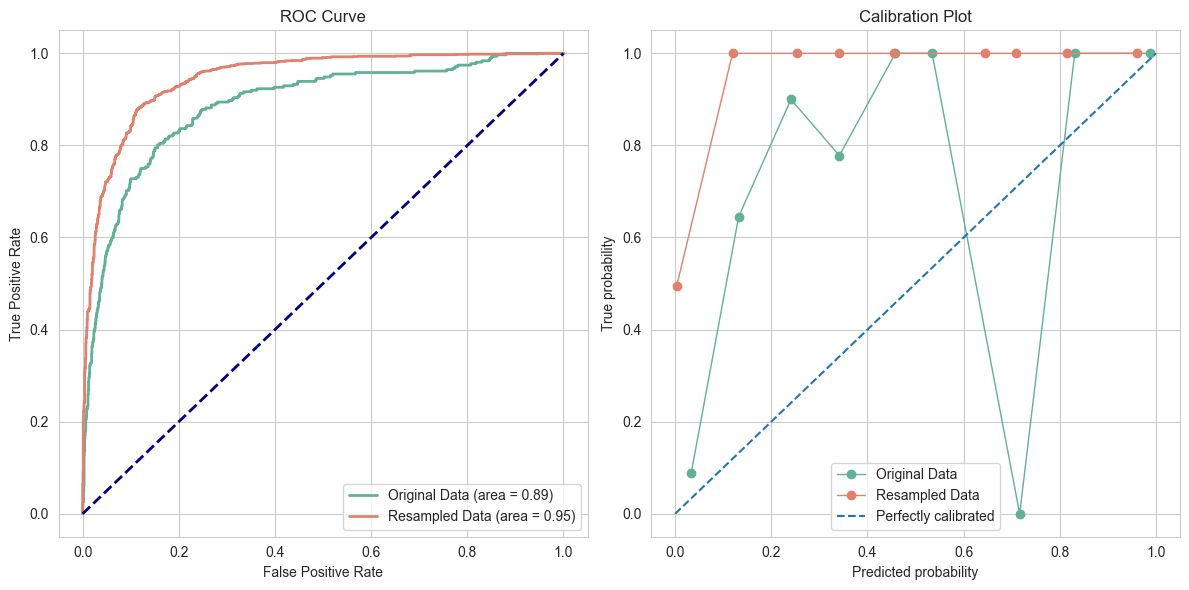

Original Data - C-index: 0.8655, ROC AUC: 0.8877, Brier Score: 0.1210
Resampled Data - C-index: 0.8487, ROC AUC: 0.9463, Brier Score: 0.4870


In [17]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, brier_score_loss
from sklearn.preprocessing import MinMaxScaler
from sklearn.calibration import calibration_curve
from lifelines.utils import concordance_index

# Function to create DMatrix
def create_dmatrix(X, y_time, y_event):
    dmatrix = xgb.DMatrix(X, label=y_time)
    dmatrix.set_float_info('label_lower_bound', y_event)
    dmatrix.set_float_info('label_upper_bound', y_event)
    return dmatrix

# Function to train model
def train_model(dtrain, params, num_boost_round=1000):
    return xgb.train(params, dtrain, num_boost_round=num_boost_round)

def evaluate_model(model, dtrain, y_time, y_event):
    risk_scores = model.predict(dtrain)
    risk_scores_scaled = MinMaxScaler().fit_transform(risk_scores.reshape(-1, 1)).flatten()
    c_index = concordance_index(y_time, -risk_scores, y_event)
    auc = roc_auc_score(y_event, risk_scores_scaled)
    brier = brier_score_loss(y_event, risk_scores_scaled)
    return risk_scores, c_index, auc, brier

# Function to plot ROC curve
def plot_roc_curve(y_event, risk_scores, label, color):
    risk_scores_scaled = MinMaxScaler().fit_transform(risk_scores.reshape(-1, 1)).flatten()
    fpr, tpr, _ = roc_curve(y_event, risk_scores_scaled)
    auc = roc_auc_score(y_event, risk_scores_scaled)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{label} (area = {auc:.2f})')
    return auc

# Function to plot calibration curve
def plot_calibration_curve(y_event, risk_scores, label, color):
    risk_scores_scaled = MinMaxScaler().fit_transform(risk_scores.reshape(-1, 1)).flatten()
    prob_true, prob_pred = calibration_curve(y_event, risk_scores_scaled, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label=label, color=color)
    return prob_true, prob_pred

# 固定的模型参数
params = {
    'objective': 'survival:cox',
    'eval_metric': 'cox-nloglik',
    'tree_method': 'hist',
    'learning_rate': 0.001,
    'max_depth': 5,
    'min_child_weight': 1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'subsample': 0.8,
    'colsample_bynode': 0.8
}

# 提取特征和标签
X = data.drop(columns=['T.O.D_180d', 'D180D'])
y_time = data['T.O.D_180d']
y_event = data['D180D']
X_resampled = data_resampled.drop(columns=['T.O.D_180d', 'D180D'])
y_time_resampled = data_resampled['T.O.D_180d']
y_event_resampled = data_resampled['D180D']

# 在原始数据上训练和评估模型
dtrain_original = create_dmatrix(X, y_time, y_event)
model_original = train_model(dtrain_original, params)
risk_scores_original, c_index_original, auc_original, brier_original = evaluate_model(model_original, dtrain_original, y_time, y_event)

# 在过采样数据上训练和评估模型
dtrain_resampled = create_dmatrix(X_resampled, y_time_resampled, y_event_resampled)
model_resampled = train_model(dtrain_resampled, params)
risk_scores_resampled, c_index_resampled, auc_resampled, brier_resampled = evaluate_model(model_resampled, dtrain_resampled, y_time_resampled, y_event_resampled)

# 画图
plt.figure(figsize=(12, 6))

# 绘制ROC曲线
plt.subplot(1, 2, 1)
plot_roc_curve(y_event, risk_scores_original, 'Original Data', '#62B197')
plot_roc_curve(y_event_resampled, risk_scores_resampled, 'Resampled Data', '#E1816D')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# 绘制校准曲线
plt.subplot(1, 2, 2)
plot_calibration_curve(y_event, risk_scores_original, 'Original Data', '#62B197')
plot_calibration_curve(y_event_resampled, risk_scores_resampled, 'Resampled Data', '#E1816D')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration Plot')
plt.legend()

plt.tight_layout()
plt.show()

# 显示结果
print(f"Original Data - C-index: {c_index_original:.4f}, ROC AUC: {auc_original:.4f}, Brier Score: {brier_original:.4f}")
print(f"Resampled Data - C-index: {c_index_resampled:.4f}, ROC AUC: {auc_resampled:.4f}, Brier Score: {brier_resampled:.4f}")


[I 2024-05-24 10:56:44,743] A new study created in memory with name: no-name-8681ee0b-f76b-4af3-b4c3-22db3cb296c8
[I 2024-05-24 10:56:45,370] Trial 0 finished with value: -0.8818583512860205 and parameters: {'learning_rate': 0.009793509730377393, 'max_depth': 10, 'min_child_weight': 2.5076117352793905, 'reg_alpha': 4.391073870233078, 'reg_lambda': 2.0622115410188413, 'subsample': 0.6974531024519601, 'colsample_bynode': 0.7290400138213302}. Best is trial 0 with value: -0.8818583512860205.
[I 2024-05-24 10:56:45,955] Trial 1 finished with value: -0.8691226747581194 and parameters: {'learning_rate': 0.007529375103476567, 'max_depth': 4, 'min_child_weight': 8.393801540292852, 'reg_alpha': 1.5144579748630957, 'reg_lambda': 1.2794847297556389, 'subsample': 0.9654774581494263, 'colsample_bynode': 0.9316554641393223}. Best is trial 0 with value: -0.8818583512860205.
[I 2024-05-24 10:56:46,431] Trial 2 finished with value: -0.8345492198741389 and parameters: {'learning_rate': 0.0060982433505204

Best Parameters: {'learning_rate': 0.009793509730377393, 'max_depth': 10, 'min_child_weight': 2.5076117352793905, 'reg_alpha': 4.391073870233078, 'reg_lambda': 2.0622115410188413, 'subsample': 0.6974531024519601, 'colsample_bynode': 0.7290400138213302}


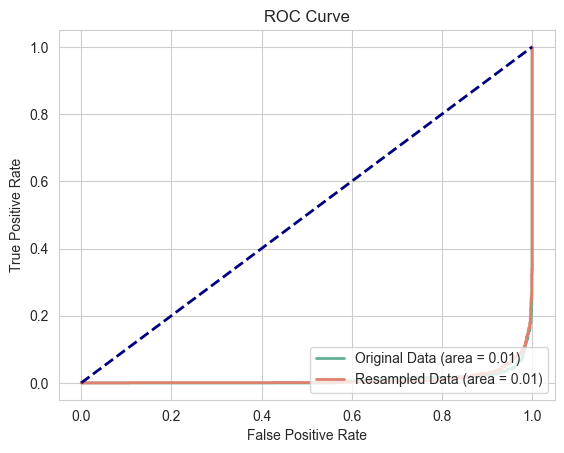

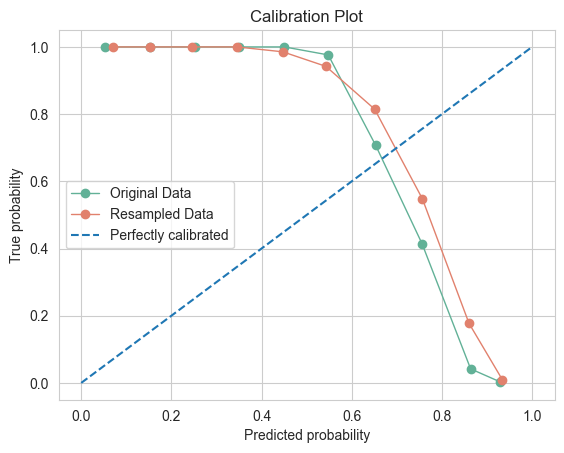

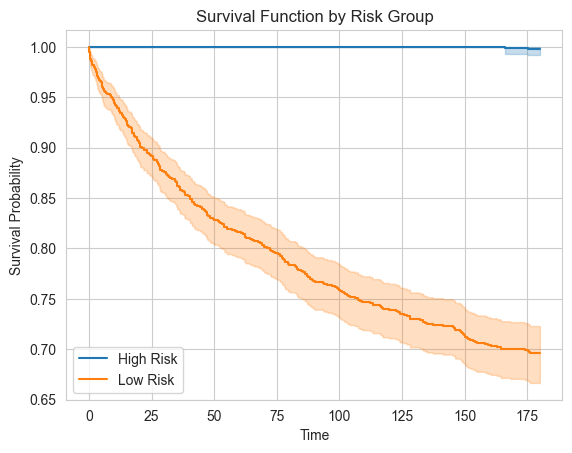

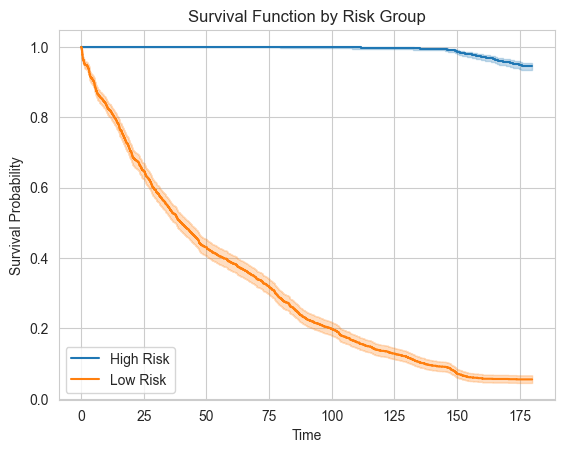

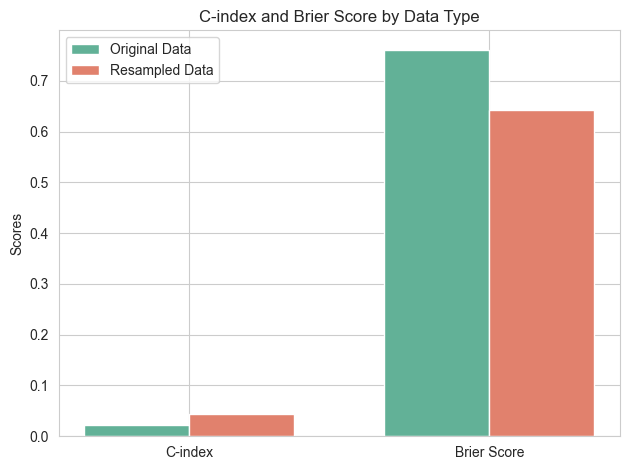

Original Data - C-index: 0.0223, ROC AUC: 0.0105, Brier Score: 0.7612
Resampled Data - C-index: 0.0436, ROC AUC: 0.0110, Brier Score: 0.6435


In [15]:
import pandas as pd
import xgboost as xgb
import optuna
from optuna import Trial
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, brier_score_loss
import numpy as np
from lifelines import KaplanMeierFitter
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import MinMaxScaler

# Function to create DMatrix
def create_dmatrix(X, y_time, y_event):
    dmatrix = xgb.DMatrix(X, label=y_time)
    dmatrix.set_float_info('label_lower_bound', y_event)
    dmatrix.set_float_info('label_upper_bound', y_event)
    return dmatrix

# Function to train model
def train_model(dtrain, params, num_boost_round=1000):
    return xgb.train(params, dtrain, num_boost_round=num_boost_round)

def evaluate_model(model, dtrain, y_time, y_event):
    risk_scores = model.predict(dtrain)
    scaler = MinMaxScaler()
    risk_scores_scaled = scaler.fit_transform(risk_scores.reshape(-1, 1)).flatten()
    risk_scores_scaled = np.clip(risk_scores_scaled, 0, 1)  # 确保风险得分在 [0, 1] 之间
    c_index = concordance_index(y_time, -risk_scores, y_event)
    auc = roc_auc_score(y_event, risk_scores_scaled)  # Use scaled risk scores here
    brier = brier_score_loss(y_event, risk_scores_scaled)
    return risk_scores, c_index, auc, brier

# Function to plot ROC curve
def plot_roc_curve(y_event, risk_scores, label, color):
    risk_scores_scaled = MinMaxScaler().fit_transform(risk_scores.reshape(-1, 1)).flatten()
    fpr, tpr, _ = roc_curve(y_event, risk_scores_scaled)
    auc = roc_auc_score(y_event, risk_scores_scaled)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{label} (area = {auc:.2f})')
    return auc

# Function to plot calibration curve
def plot_calibration_curve(y_event, risk_scores, label, color):
    risk_scores_scaled = MinMaxScaler().fit_transform(risk_scores.reshape(-1, 1)).flatten()
    prob_true, prob_pred = calibration_curve(y_event, risk_scores_scaled, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label=label, color=color)
    return prob_true, prob_pred


# Function to plot survival curves
def plot_survival_curves(risk_scores, y_time, y_event):
    kmf = KaplanMeierFitter()
    median_risk_score = np.median(risk_scores)
    high_risk = y_event[risk_scores >= median_risk_score]
    high_risk_time = y_time[risk_scores >= median_risk_score]
    low_risk = y_event[risk_scores < median_risk_score]
    low_risk_time = y_time[risk_scores < median_risk_score]
    kmf.fit(high_risk_time, event_observed=high_risk, label='High Risk')
    ax = kmf.plot_survival_function()
    kmf.fit(low_risk_time, event_observed=low_risk, label='Low Risk')
    kmf.plot_survival_function(ax=ax)
    plt.title('Survival Function by Risk Group')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability')
    plt.legend()
    plt.show()

# Optuna objective function
def objective(trial: Trial):
    params = {
        'objective': 'survival:cox',
        'eval_metric': 'cox-nloglik',
        'tree_method': 'hist',
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.01),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.01, 10.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1.0)
    }
    dtrain = create_dmatrix(X_resampled, y_time_resampled, y_event_resampled)
    model = train_model(dtrain, params)
    _, c_index, _, _ = evaluate_model(model, dtrain, y_time_resampled, y_event_resampled)
    return -c_index

# Extract features and labels for original and resampled data
X = data.drop(columns=['T.O.D_180d', 'D180D'])
y_time = data['T.O.D_180d']
y_event = data['D180D']
X_resampled = data_resampled.drop(columns=['T.O.D_180d', 'D180D'])
y_time_resampled = data_resampled['T.O.D_180d']
y_event_resampled = data_resampled['D180D']

# Optuna study for hyperparameter optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

# Best parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Train and evaluate model on original data
dtrain_original = create_dmatrix(X, y_time, y_event)
model_original = train_model(dtrain_original, best_params)
risk_scores_original, c_index_original, auc_original, brier_original = evaluate_model(model_original, dtrain_original, y_time, y_event)

# Train and evaluate model on resampled data
dtrain_resampled = create_dmatrix(X_resampled, y_time_resampled, y_event_resampled)
model_resampled = train_model(dtrain_resampled, best_params)
risk_scores_resampled, c_index_resampled, auc_resampled, brier_resampled = evaluate_model(model_resampled, dtrain_resampled, y_time_resampled, y_event_resampled)

# Plot ROC curves
plt.figure()
plot_roc_curve(y_event, risk_scores_original, 'Original Data', '#62B197')
plot_roc_curve(y_event_resampled, risk_scores_resampled, 'Resampled Data', '#E1816D')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Plot calibration curves
plt.figure()
plot_calibration_curve(y_event, risk_scores_original, 'Original Data', '#62B197')
plot_calibration_curve(y_event_resampled, risk_scores_resampled, 'Resampled Data', '#E1816D')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration Plot')
plt.legend()
plt.show()

# Plot survival curves
plot_survival_curves(risk_scores_original, y_time, y_event)
plot_survival_curves(risk_scores_resampled, y_time_resampled, y_event_resampled)

# Plot C-index and Brier Score
metrics = ['C-index', 'Brier Score']
original_metrics = [c_index_original, brier_original]
resampled_metrics = [c_index_resampled, brier_resampled]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, original_metrics, width, label='Original Data', color='#62B197')
rects2 = ax.bar(x + width/2, resampled_metrics, width, label='Resampled Data', color='#E1816D')

ax.set_ylabel('Scores')
ax.set_title('C-index and Brier Score by Data Type')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

fig.tight_layout()
plt.show()

# Display results
print(f"Original Data - C-index: {c_index_original:.4f}, ROC AUC: {auc_original:.4f}, Brier Score: {brier_original:.4f}")
print(f"Resampled Data - C-index: {c_index_resampled:.4f}, ROC AUC: {auc_resampled:.4f}, Brier Score: {brier_resampled:.4f}")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
import optuna
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

def prepare_data(data):
    X_resampled = data.drop(columns=['T.O.D_180d', 'D180D'])
    y_time_resampled = data['T.O.D_180d']
    y_event_resampled = data['D180D']
    y = np.array([(event, time) for event, time in zip(y_event_resampled, y_time_resampled)], dtype=[('event', 'bool'), ('time', 'float')])
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

def train_evaluate_model(X_train, y_train, X_test, y_test, params):
    rsf = RandomSurvivalForest(
        n_estimators=params['n_estimators'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        random_state=42
    )
    rsf.fit(X_train, y_train)
    risk_scores = rsf.predict(X_test)
    c_index = concordance_index_censored(y_test["event"], y_test["time"], risk_scores)[0]
    return rsf, risk_scores, c_index

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
    }
    _, _, c_index = train_evaluate_model(X_train, y_train, X_test, y_test, params)
    return c_index

def optimize_hyperparameters(X_train, y_train, X_test, y_test):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=500)
    return study.best_params

def normalize_scores(scores):
    min_score = np.min(scores)
    max_score = np.max(scores)
    normalized_scores = (scores - min_score) / (max_score - min_score)
    return normalized_scores

def plot_roc_curve(y_test, risk_scores):
    normalized_scores = normalize_scores(risk_scores)
    fpr, tpr, _ = roc_curve(y_test["event"], normalized_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_calibration_curve(y_test, risk_scores):
    normalized_scores = normalize_scores(risk_scores)
    prob_true, prob_pred = calibration_curve(y_test["event"], normalized_scores, n_bins=10)
    plt.figure()
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Calibration curve')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration Curve')
    plt.legend(loc='best')
    plt.show()

def plot_survival_function(y_test, risk_scores):
    median_risk_score = np.median(risk_scores)
    high_risk = y_test[risk_scores >= median_risk_score]
    low_risk = y_test[risk_scores < median_risk_score]
    kmf = KaplanMeierFitter()
    ax = kmf.fit(high_risk["time"], event_observed=high_risk["event"], label='High Risk').plot_survival_function()
    kmf.fit(low_risk["time"], event_observed=low_risk["event"], label='Low Risk').plot_survival_function(ax=ax)
    plt.title('Survival Function by Risk Group')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability')
    plt.legend()
    plt.show()

def main(data):
    X_train, X_test, y_train, y_test = prepare_data(data)
    best_params = optimize_hyperparameters(X_train, y_train, X_test, y_test)
    rsf, risk_scores, c_index = train_evaluate_model(X_train, y_train, X_test, y_test, best_params)
    print("C-index:", c_index)
    plot_roc_curve(y_test, risk_scores)
    plot_calibration_curve(y_test, risk_scores)
    plot_survival_function(y_test, risk_scores)

# Assuming `data_resampled` is your input DataFrame
# main(data_resampled)
main(data)

[I 2024-05-24 15:37:38,509] A new study created in memory with name: no-name-e73c8579-5a36-494f-b538-fb8bb63145d4


[15:55:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


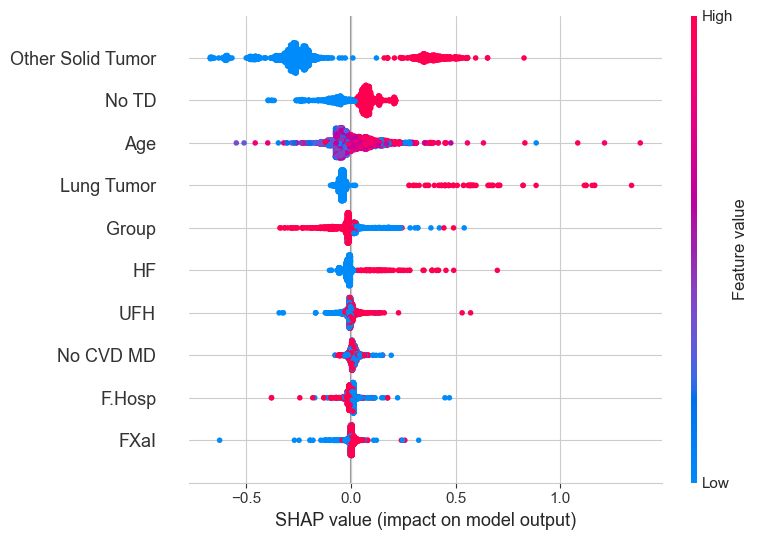

In [14]:
import shap

# 创建解释器
explainer = shap.TreeExplainer(model)

# 计算SHAP值
shap_values = explainer.shap_values(X)

# 绘制SHAP值的总结图
shap.summary_plot(shap_values, X)

[10:12:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


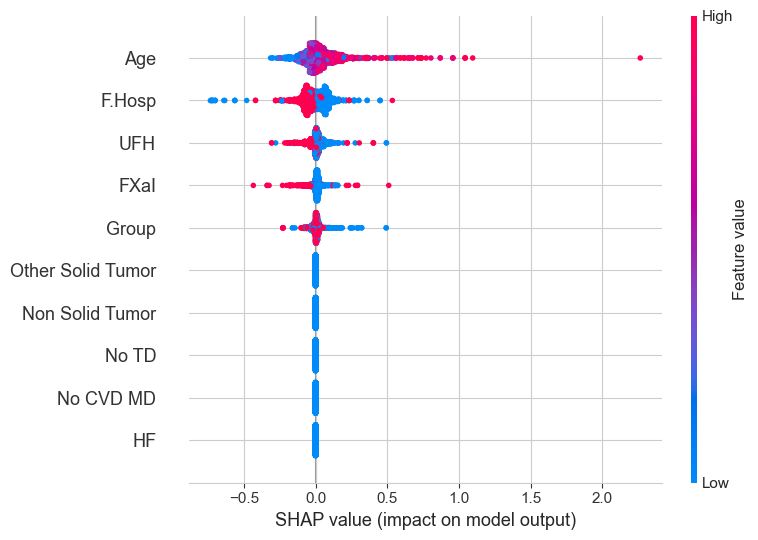

In [13]:
import shap

# 创建解释器
explainer = shap.TreeExplainer(model)

# 计算SHAP值
shap_values = explainer.shap_values(X)

# 绘制SHAP值的总结图
shap.summary_plot(shap_values, X)